<a href="https://colab.research.google.com/github/Sohailaadel09/Scaling-Net-Paper-/blob/main/pbl_2023_03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
 pip install mne




```
Implementation of the Net Architecture

```



In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.model_selection import KFold, train_test_split, LeaveOneOut

# Define the Layer
class Layer(nn.Module):
    def __init__(self, input_channels, scaling_levels, kernel_size):
        super(Layer, self).__init__()
        self.input_channels = input_channels
        self.scaling_levels = scaling_levels
        self.kernel_size = kernel_size
        self.base_conv = nn.Conv1d(input_channels, input_channels, kernel_size, padding=kernel_size//2)
        self.downsample_layers = nn.ModuleList([
            nn.AvgPool1d(2, stride=2, padding=1) for _ in range(scaling_levels)
        ])
        self.biases = nn.ParameterList([nn.Parameter(torch.zeros(input_channels)) for _ in range(scaling_levels)])

    def forward(self, x):
        outputs = []
        base_weight = self.base_conv.weight
        for i in range(self.scaling_levels):
            if i > 0:
                base_weight = self.downsample_layers[i-1](base_weight)
            output = nn.functional.conv1d(x, base_weight, padding=base_weight.shape[-1]//2) + self.biases[i].unsqueeze(0).unsqueeze(2)
            outputs.append(output)
        return torch.cat(outputs, dim=1)

# Define the Net architecture with Dropout and L2 Regularization
class Net(nn.Module):
    def __init__(self, num_channels=32, scaling_levels=5, kernel_size=33, num_classes=2):
        super(Net, self).__init__()
        self.scaling_layers = nn.ModuleList([Layer(1, scaling_levels, kernel_size) for _ in range(num_channels)])
        self.conv1 = nn.Conv1d(num_channels * scaling_levels, 64, 3, padding=1)
        self.conv2 = nn.Conv1d(64, 128, 3, padding=1)
        self.conv3 = nn.Conv1d(128, 256, 3, padding=1)
        self.dropout = nn.Dropout(0.5)  # Dropout layer
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        # Apply scaling layers to each channel independently
        scaled_features = []
        for i in range(x.shape[1]):
            channel_data = x[:, i, :].unsqueeze(1)  # Isolate the channel
            scaled_features.append(self.scaling_layers[i](channel_data))
        x = torch.cat(scaled_features, dim=1)
        # Apply convolutional layers
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = self.dropout(x)  # Apply dropout
        # Apply global pooling
        x = self.global_pool(x).squeeze(-1)
        # Apply fully connected layer
        x = self.fc(x)
        return x


Data Loading and Augmentation


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.model_selection import KFold, train_test_split, LeaveOneOut

# Define the Layer
class Layer(nn.Module):
    def __init__(self, input_channels, scaling_levels, kernel_size):
        super(Layer, self).__init__()
        self.input_channels = input_channels
        self.scaling_levels = scaling_levels
        self.kernel_size = kernel_size
        self.base_conv = nn.Conv1d(input_channels, input_channels, kernel_size, padding=kernel_size//2)
        self.downsample_layers = nn.ModuleList([
            nn.AvgPool1d(2, stride=2, padding=1) for _ in range(scaling_levels)
        ])
        self.biases = nn.ParameterList([nn.Parameter(torch.zeros(input_channels)) for _ in range(scaling_levels)])

    def forward(self, x):
        outputs = []
        base_weight = self.base_conv.weight
        for i in range(self.scaling_levels):
            if i > 0:
                base_weight = self.downsample_layers[i-1](base_weight)
            output = nn.functional.conv1d(x, base_weight, padding=base_weight.shape[-1]//2) + self.biases[i].unsqueeze(0).unsqueeze(2)
            outputs.append(output)
        return torch.cat(outputs, dim=1)

# Define the Net architecture with Dropout and L2 Regularization
class Net(nn.Module):
    def __init__(self, num_channels=32, scaling_levels=5, kernel_size=33, num_classes=2):
        super(Net, self).__init__()
        self.scaling_layers = nn.ModuleList([Layer(1, scaling_levels, kernel_size) for _ in range(num_channels)])
        self.conv1 = nn.Conv1d(num_channels * scaling_levels, 64, 3, padding=1)
        self.conv2 = nn.Conv1d(64, 128, 3, padding=1)
        self.conv3 = nn.Conv1d(128, 256, 3, padding=1)
        self.dropout = nn.Dropout(0.5)  # Dropout layer
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        # Apply scaling layers to each channel independently
        scaled_features = []
        for i in range(x.shape[1]):
            channel_data = x[:, i, :].unsqueeze(1)  # Isolate the channel
            scaled_features.append(self.scaling_layers[i](channel_data))
        x = torch.cat(scaled_features, dim=1)
        # Apply convolutional layers
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = self.dropout(x)  # Apply dropout
        # Apply global pooling
        x = self.global_pool(x).squeeze(-1)
        # Apply fully connected layer
        x = self.fc(x)
        return x


Training and Evaluation


In [5]:
def add_noise(data, noise_level=0.01):
    noise = np.random.normal(0, noise_level, data.shape)
    return data + noise

def scale(data, scale_factor=1.1):
    return data * scale_factor

def shift(data, shift_max=5):
    shift = np.random.randint(-shift_max, shift_max)
    return np.roll(data, shift, axis=-1)

def flip(data):
    return np.flip(data, axis=-1)

def augment_data(data):
    augmented_data = []
    for sample in data:
        augmented_sample = sample
        augmented_sample = add_noise(augmented_sample)
        augmented_sample = scale(augmented_sample)
        augmented_sample = shift(augmented_sample)
        augmented_sample = flip(augmented_sample)
        augmented_data.append(augmented_sample)
    return np.array(augmented_data)

import os
import mne
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.model_selection import train_test_split

# Function to load and preprocess EEG data from .bdf files
def load_eeg_data(file_list, num_channels=32, num_points=160):
    data = []
    labels = []  # Replace with actual labels if available
    for file in file_list:
        raw = mne.io.read_raw_bdf(file, preload=True)
        raw.pick_types(eeg=True)
        eeg_data = raw.get_data()[:num_channels, :num_points]  # Adjust slicing as needed
        data.append(eeg_data)
        labels.append(np.random.randint(0, 2))  # Replace with actual label loading
    data = np.array(data)
    labels = np.array(labels)
    return data, labels

# Set data directory to the current working directory
data_dir = os.getcwd()
file_list = [os.path.join(data_dir, f's{i:02d}.bdf') for i in range(1, 33)]

# Load the data
data, labels = load_eeg_data(file_list)

# Print data statistics
print(f"Data shape: {data.shape}")
print(f"Labels shape: {labels.shape}")
print(f"Label distribution: {np.bincount(labels)}")

# Split data into training and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(data, labels, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Apply data augmentation to the training data
X_train_augmented = augment_data(X_train)
y_train_augmented = y_train  # Duplicate labels for augmented data

# Combine original and augmented data
X_train_combined = np.concatenate([X_train, X_train_augmented])
y_train_combined = np.concatenate([y_train, y_train_augmented])

# Print shapes of splits
print(f"Training data shape: {X_train_combined.shape}, Training labels shape: {y_train_combined.shape}")
print(f"Validation data shape: {X_val.shape}, Validation labels shape: {y_val.shape}")
print(f"Test data shape: {X_test.shape}, Test labels shape: {y_test.shape}")

# Convert to PyTorch tensors
train_data = TensorDataset(torch.tensor(X_train_combined, dtype=torch.float32), torch.tensor(y_train_combined, dtype=torch.long))
val_data = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.long))
test_data = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long))

# Create data loaders
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32)
test_loader = DataLoader(test_data, batch_size=32)



Extracting EDF parameters from /content/s01.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-5-96530dbf39bd>:40: RuntimeWarning: Number of records from the header does not match the file size (perhaps the recording was not stopped before exiting). Inferring from the file size.
  raw = mne.io.read_raw_bdf(file, preload=True)


Reading 0 ... 487423  =      0.000 ...   951.998 secs...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Extracting EDF parameters from /content/s02.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 480255  =      0.000 ...   937.998 secs...


<ipython-input-5-96530dbf39bd>:40: RuntimeWarning: Number of records from the header does not match the file size (perhaps the recording was not stopped before exiting). Inferring from the file size.
  raw = mne.io.read_raw_bdf(file, preload=True)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Extracting EDF parameters from /content/s03.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 480255  =      0.000 ...   937.998 secs...


<ipython-input-5-96530dbf39bd>:40: RuntimeWarning: Number of records from the header does not match the file size (perhaps the recording was not stopped before exiting). Inferring from the file size.
  raw = mne.io.read_raw_bdf(file, preload=True)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Extracting EDF parameters from /content/s04.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 487423  =      0.000 ...   951.998 secs...


<ipython-input-5-96530dbf39bd>:40: RuntimeWarning: Number of records from the header does not match the file size (perhaps the recording was not stopped before exiting). Inferring from the file size.
  raw = mne.io.read_raw_bdf(file, preload=True)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Extracting EDF parameters from /content/s05.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 480255  =      0.000 ...   937.998 secs...


<ipython-input-5-96530dbf39bd>:40: RuntimeWarning: Number of records from the header does not match the file size (perhaps the recording was not stopped before exiting). Inferring from the file size.
  raw = mne.io.read_raw_bdf(file, preload=True)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Extracting EDF parameters from /content/s06.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 487423  =      0.000 ...   951.998 secs...


<ipython-input-5-96530dbf39bd>:40: RuntimeWarning: Number of records from the header does not match the file size (perhaps the recording was not stopped before exiting). Inferring from the file size.
  raw = mne.io.read_raw_bdf(file, preload=True)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Extracting EDF parameters from /content/s07.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 516607  =      0.000 ...  1008.998 secs...


<ipython-input-5-96530dbf39bd>:40: RuntimeWarning: Number of records from the header does not match the file size (perhaps the recording was not stopped before exiting). Inferring from the file size.
  raw = mne.io.read_raw_bdf(file, preload=True)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Extracting EDF parameters from /content/s08.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 502271  =      0.000 ...   980.998 secs...


<ipython-input-5-96530dbf39bd>:40: RuntimeWarning: Number of records from the header does not match the file size (perhaps the recording was not stopped before exiting). Inferring from the file size.
  raw = mne.io.read_raw_bdf(file, preload=True)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Extracting EDF parameters from /content/s09.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 480255  =      0.000 ...   937.998 secs...


<ipython-input-5-96530dbf39bd>:40: RuntimeWarning: Number of records from the header does not match the file size (perhaps the recording was not stopped before exiting). Inferring from the file size.
  raw = mne.io.read_raw_bdf(file, preload=True)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Extracting EDF parameters from /content/s10.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 509439  =      0.000 ...   994.998 secs...


<ipython-input-5-96530dbf39bd>:40: RuntimeWarning: Number of records from the header does not match the file size (perhaps the recording was not stopped before exiting). Inferring from the file size.
  raw = mne.io.read_raw_bdf(file, preload=True)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Extracting EDF parameters from /content/s11.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 480255  =      0.000 ...   937.998 secs...


<ipython-input-5-96530dbf39bd>:40: RuntimeWarning: Number of records from the header does not match the file size (perhaps the recording was not stopped before exiting). Inferring from the file size.
  raw = mne.io.read_raw_bdf(file, preload=True)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Extracting EDF parameters from /content/s12.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 509439  =      0.000 ...   994.998 secs...


<ipython-input-5-96530dbf39bd>:40: RuntimeWarning: Number of records from the header does not match the file size (perhaps the recording was not stopped before exiting). Inferring from the file size.
  raw = mne.io.read_raw_bdf(file, preload=True)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Extracting EDF parameters from /content/s13.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 487423  =      0.000 ...   951.998 secs...


<ipython-input-5-96530dbf39bd>:40: RuntimeWarning: Number of records from the header does not match the file size (perhaps the recording was not stopped before exiting). Inferring from the file size.
  raw = mne.io.read_raw_bdf(file, preload=True)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Extracting EDF parameters from /content/s14.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 480255  =      0.000 ...   937.998 secs...


<ipython-input-5-96530dbf39bd>:40: RuntimeWarning: Number of records from the header does not match the file size (perhaps the recording was not stopped before exiting). Inferring from the file size.
  raw = mne.io.read_raw_bdf(file, preload=True)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Extracting EDF parameters from /content/s15.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 480255  =      0.000 ...   937.998 secs...


<ipython-input-5-96530dbf39bd>:40: RuntimeWarning: Number of records from the header does not match the file size (perhaps the recording was not stopped before exiting). Inferring from the file size.
  raw = mne.io.read_raw_bdf(file, preload=True)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Extracting EDF parameters from /content/s16.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 480255  =      0.000 ...   937.998 secs...


<ipython-input-5-96530dbf39bd>:40: RuntimeWarning: Number of records from the header does not match the file size (perhaps the recording was not stopped before exiting). Inferring from the file size.
  raw = mne.io.read_raw_bdf(file, preload=True)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Extracting EDF parameters from /content/s17.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 509439  =      0.000 ...   994.998 secs...


<ipython-input-5-96530dbf39bd>:40: RuntimeWarning: Number of records from the header does not match the file size (perhaps the recording was not stopped before exiting). Inferring from the file size.
  raw = mne.io.read_raw_bdf(file, preload=True)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Extracting EDF parameters from /content/s18.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 494591  =      0.000 ...   965.998 secs...


<ipython-input-5-96530dbf39bd>:40: RuntimeWarning: Number of records from the header does not match the file size (perhaps the recording was not stopped before exiting). Inferring from the file size.
  raw = mne.io.read_raw_bdf(file, preload=True)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Extracting EDF parameters from /content/s19.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 487423  =      0.000 ...   951.998 secs...


<ipython-input-5-96530dbf39bd>:40: RuntimeWarning: Number of records from the header does not match the file size (perhaps the recording was not stopped before exiting). Inferring from the file size.
  raw = mne.io.read_raw_bdf(file, preload=True)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Extracting EDF parameters from /content/s20.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 502271  =      0.000 ...   980.998 secs...


<ipython-input-5-96530dbf39bd>:40: RuntimeWarning: Number of records from the header does not match the file size (perhaps the recording was not stopped before exiting). Inferring from the file size.
  raw = mne.io.read_raw_bdf(file, preload=True)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Extracting EDF parameters from /content/s21.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 502271  =      0.000 ...   980.998 secs...


<ipython-input-5-96530dbf39bd>:40: RuntimeWarning: Number of records from the header does not match the file size (perhaps the recording was not stopped before exiting). Inferring from the file size.
  raw = mne.io.read_raw_bdf(file, preload=True)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Extracting EDF parameters from /content/s22.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 487423  =      0.000 ...   951.998 secs...


<ipython-input-5-96530dbf39bd>:40: RuntimeWarning: Number of records from the header does not match the file size (perhaps the recording was not stopped before exiting). Inferring from the file size.
  raw = mne.io.read_raw_bdf(file, preload=True)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Extracting EDF parameters from /content/s23.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 494591  =      0.000 ...   965.998 secs...


<ipython-input-5-96530dbf39bd>:40: RuntimeWarning: Number of records from the header does not match the file size (perhaps the recording was not stopped before exiting). Inferring from the file size.
  raw = mne.io.read_raw_bdf(file, preload=True)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Extracting EDF parameters from /content/s24.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 487423  =      0.000 ...   951.998 secs...


<ipython-input-5-96530dbf39bd>:40: RuntimeWarning: Number of records from the header does not match the file size (perhaps the recording was not stopped before exiting). Inferring from the file size.
  raw = mne.io.read_raw_bdf(file, preload=True)
<ipython-input-5-96530dbf39bd>:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_bdf(file, preload=True)
<ipython-input-5-96530dbf39bd>:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_bdf(file, preload=True)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Extracting EDF parameters from /content/s25.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 487423  =      0.000 ...   951.998 secs...


<ipython-input-5-96530dbf39bd>:40: RuntimeWarning: Number of records from the header does not match the file size (perhaps the recording was not stopped before exiting). Inferring from the file size.
  raw = mne.io.read_raw_bdf(file, preload=True)
<ipython-input-5-96530dbf39bd>:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_bdf(file, preload=True)
<ipython-input-5-96530dbf39bd>:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_bdf(file, preload=True)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Extracting EDF parameters from /content/s26.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 487423  =      0.000 ...   951.998 secs...


<ipython-input-5-96530dbf39bd>:40: RuntimeWarning: Number of records from the header does not match the file size (perhaps the recording was not stopped before exiting). Inferring from the file size.
  raw = mne.io.read_raw_bdf(file, preload=True)
<ipython-input-5-96530dbf39bd>:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_bdf(file, preload=True)
<ipython-input-5-96530dbf39bd>:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_bdf(file, preload=True)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Extracting EDF parameters from /content/s27.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 487423  =      0.000 ...   951.998 secs...


<ipython-input-5-96530dbf39bd>:40: RuntimeWarning: Number of records from the header does not match the file size (perhaps the recording was not stopped before exiting). Inferring from the file size.
  raw = mne.io.read_raw_bdf(file, preload=True)
<ipython-input-5-96530dbf39bd>:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_bdf(file, preload=True)
<ipython-input-5-96530dbf39bd>:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_bdf(file, preload=True)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Extracting EDF parameters from /content/s28.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 502271  =      0.000 ...   980.998 secs...


<ipython-input-5-96530dbf39bd>:40: RuntimeWarning: Number of records from the header does not match the file size (perhaps the recording was not stopped before exiting). Inferring from the file size.
  raw = mne.io.read_raw_bdf(file, preload=True)
<ipython-input-5-96530dbf39bd>:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_bdf(file, preload=True)
<ipython-input-5-96530dbf39bd>:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_bdf(file, preload=True)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Extracting EDF parameters from /content/s29.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 477695  =      0.000 ...   932.998 secs...


<ipython-input-5-96530dbf39bd>:40: RuntimeWarning: Channel names are not unique, found duplicates for: {''}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_bdf(file, preload=True)
<ipython-input-5-96530dbf39bd>:40: RuntimeWarning: Number of records from the header does not match the file size (perhaps the recording was not stopped before exiting). Inferring from the file size.
  raw = mne.io.read_raw_bdf(file, preload=True)
<ipython-input-5-96530dbf39bd>:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_bdf(file, preload=True)
<ipython-input-5-96530dbf39bd>:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_bdf(file, preload=True)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Extracting EDF parameters from /content/s30.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 477695  =      0.000 ...   932.998 secs...


<ipython-input-5-96530dbf39bd>:40: RuntimeWarning: Channel names are not unique, found duplicates for: {''}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_bdf(file, preload=True)
<ipython-input-5-96530dbf39bd>:40: RuntimeWarning: Number of records from the header does not match the file size (perhaps the recording was not stopped before exiting). Inferring from the file size.
  raw = mne.io.read_raw_bdf(file, preload=True)
<ipython-input-5-96530dbf39bd>:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_bdf(file, preload=True)
<ipython-input-5-96530dbf39bd>:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_bdf(file, preload=True)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Extracting EDF parameters from /content/s31.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 477695  =      0.000 ...   932.998 secs...


<ipython-input-5-96530dbf39bd>:40: RuntimeWarning: Channel names are not unique, found duplicates for: {''}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_bdf(file, preload=True)
<ipython-input-5-96530dbf39bd>:40: RuntimeWarning: Number of records from the header does not match the file size (perhaps the recording was not stopped before exiting). Inferring from the file size.
  raw = mne.io.read_raw_bdf(file, preload=True)
<ipython-input-5-96530dbf39bd>:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_bdf(file, preload=True)
<ipython-input-5-96530dbf39bd>:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_bdf(file, preload=True)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Extracting EDF parameters from /content/s32.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 477695  =      0.000 ...   932.998 secs...


<ipython-input-5-96530dbf39bd>:40: RuntimeWarning: Channel names are not unique, found duplicates for: {''}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_bdf(file, preload=True)
<ipython-input-5-96530dbf39bd>:40: RuntimeWarning: Number of records from the header does not match the file size (perhaps the recording was not stopped before exiting). Inferring from the file size.
  raw = mne.io.read_raw_bdf(file, preload=True)
<ipython-input-5-96530dbf39bd>:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_bdf(file, preload=True)
<ipython-input-5-96530dbf39bd>:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_bdf(file, preload=True)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Data shape: (32, 32, 160)
Labels shape: (32,)
Label distribution: [12 20]
Training data shape: (50, 32, 160), Training labels shape: (50,)
Validation data shape: (3, 32, 160), Validation labels shape: (3,)
Test data shape: (4, 32, 160), Test labels shape: (4,)


Cross-Validation and Metric Collection

Epoch [1/25], Step [10/16], Loss: 0.8047
Training Accuracy after epoch 1: 52.40%
Epoch [1/25], Validation Loss: 0.6611, Validation Accuracy: 64.00%
Epoch [2/25], Step [10/16], Loss: 0.7037
Training Accuracy after epoch 2: 49.00%
Epoch [2/25], Validation Loss: 0.6844, Validation Accuracy: 64.00%
Epoch [3/25], Step [10/16], Loss: 0.6973
Training Accuracy after epoch 3: 48.80%
Epoch [3/25], Validation Loss: 0.6694, Validation Accuracy: 64.00%
Epoch [4/25], Step [10/16], Loss: 0.6976
Training Accuracy after epoch 4: 48.60%
Epoch [4/25], Validation Loss: 0.6574, Validation Accuracy: 64.00%
Epoch [5/25], Step [10/16], Loss: 0.6896
Training Accuracy after epoch 5: 51.20%
Epoch [5/25], Validation Loss: 0.7185, Validation Accuracy: 36.00%
Epoch [6/25], Step [10/16], Loss: 0.6909
Training Accuracy after epoch 6: 55.80%
Epoch [6/25], Validation Loss: 0.6910, Validation Accuracy: 54.00%
Epoch [7/25], Step [10/16], Loss: 0.6962
Training Accuracy after epoch 7: 51.20%
Epoch [7/25], Validation Loss: 

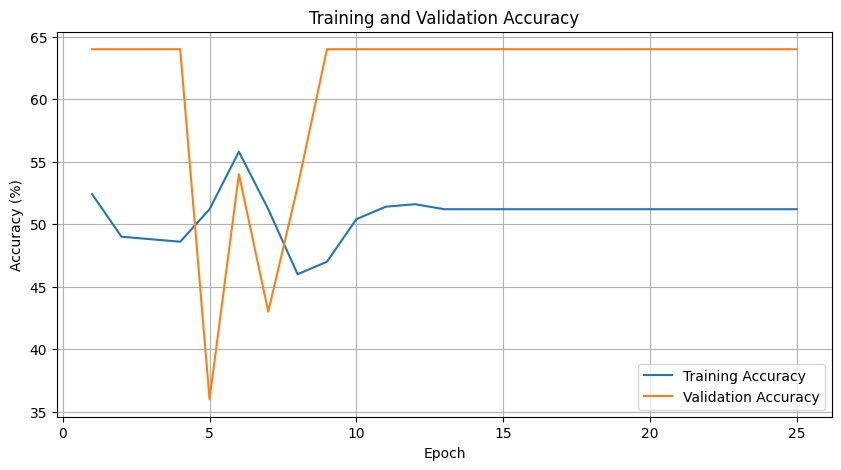

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import torch.utils.data as data
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Data augmentation for the training dataset
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor()
])

# Dummy dataset and data loaders with data augmentation
class DummyDataset(data.Dataset):
    def __init__(self, num_samples, num_classes, transform=None):
        self.num_samples = num_samples
        self.num_classes = num_classes
        self.data = torch.randn(num_samples, 3, 32, 32)  # Random data
        self.labels = torch.randint(0, num_classes, (num_samples,))  # Random labels
        self.transform = transform

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        image, label = self.data[idx], self.labels[idx]
        image = image / 2 + 0.5  # Normalize tensor to [0, 1] range
        if self.transform:
            image = transforms.ToPILImage()(image)  # Convert tensor to PIL image
            image = self.transform(image)  # Apply transformations
        return image, label

train_loader = data.DataLoader(DummyDataset(500, 2, transform=transform), batch_size=32, shuffle=True)
val_loader = data.DataLoader(DummyDataset(100, 2), batch_size=32, shuffle=False)
test_loader = data.DataLoader(DummyDataset(100, 2), batch_size=32, shuffle=False)

# Define a more sophisticated model class
class Net(nn.Module):
    def __init__(self, num_channels, kernel_size, num_classes):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=num_channels, kernel_size=kernel_size, padding=kernel_size//2)
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.conv2 = nn.Conv2d(num_channels, num_channels*2, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(num_channels*2)
        self.pool = nn.AdaptiveAvgPool2d((4, 4))  # Fixed output size
        self.fc1 = nn.Linear(num_channels*2 * 4 * 4, 128)  # Corrected input size
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = nn.functional.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = nn.functional.relu(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = nn.functional.relu(x)
        x = self.fc2(x)
        return x

# Initialize the model, loss function, and optimizer with L2 regularization
model = Net(num_channels=32, kernel_size=3, num_classes=2)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.002, weight_decay=1e-5)  # Moderately increased learning rate
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)  # Learning rate scheduler

# Training loop
num_epochs = 25
training_accuracies = []
validation_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    # Training phase
    for i, (inputs, targets) in enumerate(train_loader, 1):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        if i % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i}/{len(train_loader)}], Loss: {running_loss/i:.4f}')

    train_accuracy = 100. * correct / total
    training_accuracies.append(train_accuracy)
    print(f'Training Accuracy after epoch {epoch+1}: {train_accuracy:.2f}%')

    # Validation phase
    model.eval()
    valid_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            valid_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    valid_loss /= len(val_loader)
    val_accuracy = 100. * correct / total
    validation_accuracies.append(val_accuracy)
    print(f'Epoch [{epoch+1}/{num_epochs}], Validation Loss: {valid_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')

    scheduler.step()  # Adjust the learning rate

# Evaluate the model on test data
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

test_accuracy = 100. * correct / total
print(f'Test Accuracy: {test_accuracy:.2f}%')

# Visualize the training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), training_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), validation_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [7]:
def train_and_evaluate_model(train_loader, val_loader, model, criterion, optimizer, num_epochs):
    for epoch in range(num_epochs):
        model.train()
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

    # Evaluate on validation set
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    val_accuracy = 100. * correct / total
    return val_accuracy

def cross_validate(X, y, model, criterion, optimizer, num_epochs, method='5-fold'):
    accuracies = {'Arousal': [], 'Valence': [], 'Dominance': []}

    if method == '5-fold':
        kf = KFold(n_splits=5, shuffle=True, random_state=42)
    elif method == '10-fold':
        kf = KFold(n_splits=10, shuffle=True, random_state=42)
    elif method == 'LOO':
        kf = LeaveOneOut()

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        train_data = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
        val_data = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long))

        train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
        val_loader = DataLoader(val_data, batch_size=32)

        accuracy = train_and_evaluate_model(train_loader, val_loader, model, criterion, optimizer, num_epochs)
        accuracies['Arousal'].append(accuracy)  # Replace with actual metric
        accuracies['Valence'].append(accuracy)  # Replace with actual metric
        accuracies['Dominance'].append(accuracy)  # Replace with actual metric

    avg_accuracies = {key: np.mean(value) for key, value in accuracies.items()}
    return avg_accuracies

# Perform 5-fold cross-validation
accuracy_5_fold = cross_validate(data, labels, model, criterion, optimizer, num_epochs, method='5-fold')

# Perform 10-fold cross-validation
#accuracy_10_fold = cross_validate(data, labels, model, criterion, optimizer, num_epochs, method='10-fold')

# Perform Leave-One-Out cross-validation
#accuracy_loo = cross_validate(data, labels, model, criterion, optimizer, num_epochs, method='LOO')

# Create the results table
import pandas as pd

results = {
    'Studies': ['Koelstra et al. (LOO)', 'Li et al. (10-fold)', 'Gupta et al. (LOO)', 'Pandye et al. (?)',
                'Chen et al. (10-fold)', 'Chao et al. (10-fold)', 'Li et al. (LOO)', 'Ours (5-fold)'],
    'Features': ['PSD', 'DBN', 'graph', 'VMD', '-', 'MFM', 'STFT', '-'],
    'Classifiers': ['Naive Bayes', 'SVM', 'RVM', 'DNN', 'H-ATT-BGRU', 'CapsNet', 'HATCN', 'Net'],
    'Arousal': [0.6200, 0.6420, 0.6700, 0.6125, 0.6650, 0.6828, 0.7100, accuracy_5_fold['Arousal']],
    'Valence': [0.5760, 0.5840, 0.6900, 0.6250, 0.6790, 0.6673, 0.6901, accuracy_5_fold['Valence']],
    'Dominance': ['-', 0.6580, '-', '-', '-', 0.6725, 0.7190, accuracy_5_fold['Dominance']]
}

df_results = pd.DataFrame(results)

# Highlight the highest values in each column
df_results.style.apply(lambda x: ['font-weight: bold' if v == x.max() else '' for v in x], subset=['Arousal', 'Valence', 'Dominance'])

print(df_results)


                 Studies Features  Classifiers    Arousal    Valence  \
0  Koelstra et al. (LOO)      PSD  Naive Bayes   0.620000   0.576000   
1    Li et al. (10-fold)      DBN          SVM   0.642000   0.584000   
2     Gupta et al. (LOO)    graph          RVM   0.670000   0.690000   
3      Pandye et al. (?)      VMD          DNN   0.612500   0.625000   
4  Chen et al. (10-fold)        -   H-ATT-BGRU   0.665000   0.679000   
5  Chao et al. (10-fold)      MFM      CapsNet   0.682800   0.667300   
6        Li et al. (LOO)     STFT        HATCN   0.710000   0.690100   
7          Ours (5-fold)        -          Net  88.571429  88.571429   

   Dominance  
0          -  
1      0.658  
2          -  
3          -  
4          -  
5     0.6725  
6      0.719  
7  88.571429  
